In [ ]:
using Polynomials, Random, Plots, Statistics, StatsBase

In [163]:
original_function(x) = sin(x)*exp(-x)*10

x_min = 0
x_max = 5

x_samples = sort(rand(15) * (x_max - x_min) .+ x_min)
y_samples = original_function.(x_samples)
n = length(x_samples)
x_vals_universal = range(x_min, x_max, length=100)
nothing

### Zadanie 1

#### Implementacja Langranga

In [ ]:
function lagrange_interpolation(x_points, y_points, x)
    n = length(x_points)
    result = 0.0
    for i in 1:n
        L_i = 1.0
        for j in 1:n
            if i != j
                L_i *= (x - x_points[j]) / (x_points[i] - x_points[j])
            end
        end
        result += y_points[i] * L_i
    end
    return result
end
nothing

#### Lagrange visualisation

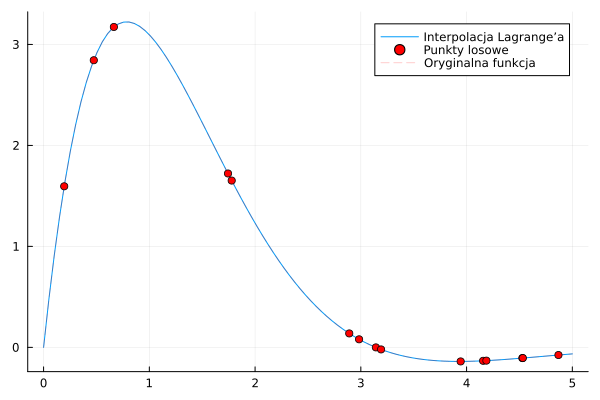

In [165]:
y_vals_lagrange = [lagrange_interpolation(x_samples, y_samples, x) for x in x_vals_universal]

plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a")
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal),label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

### Zadanie 2

### Wielomian interpolacyjny Newtona

Postać ogólna:

$$
P_n(x) = f[x_0] + f[x_0, x_1](x - x_0) + f[x_0, x_1, x_2](x - x_0)(x - x_1) + \dots + f[x_0, x_1, \dots, x_n](x - x_0)(x - x_1) \dots (x - x_{n-1})
$$

---
Można uprościć do

$$
P_n(x) = f[x_0] + (x - x_0) [ f[x_0, x_1] + (x - x_1)[ f[x_0, x_1, x_2] + \dots + f[x_0, x_1, \dots, x_n] \dots (x - x_{n-1}) ]]
$$




![Wzór newtona cuted.png](<attachment:Wzór newtona cuted.png>)
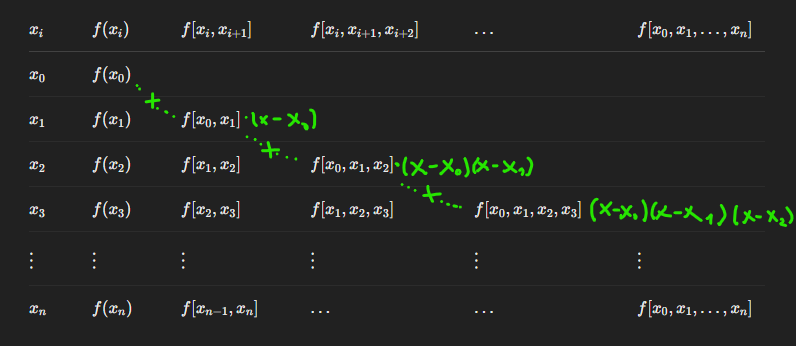

#### Implementacja tworzenia obiektu interpolacyjnego

In [132]:
function NewtonInterpolation(x_samples, y_samples)
    # n = length(x_samples)
    T = zeros(n, n)

    for i in 1:n
        T[i, 1] = y_samples[i]
    end

    for col in 2:n
        for row in col:n
            T[row, col] = 
                (T[row, col-1] - T[row-1, col-1]) / 
                (x_samples[row] - x_samples[row-col+1])
        end
    end

    return T
end
nothing

#### Funkcja licząca wartość wileomianu dla newt

In [133]:
function NewtonHorner(newt, x, x_samples)
    # n = size(newt, 1)
    result = newt[n, n]
    for i in (n-1):-1:1
        result = result * (x - x_samples[i]) + newt[i, i]
    end
    return result
end
nothing

#### Newton Visualisation

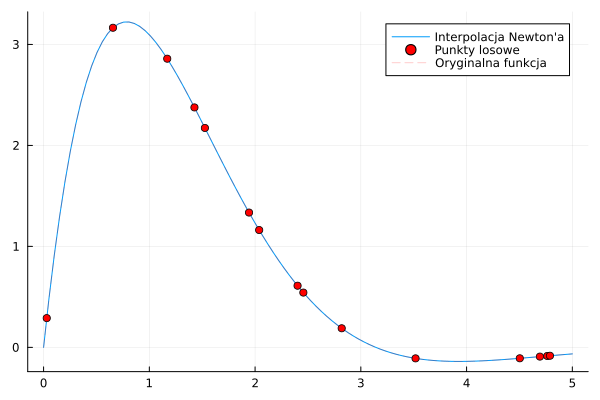

In [134]:
newt = NewtonInterpolation(x_samples, y_samples)  # Tworzenie obiektu interpolacyjnego

y_vals_newton = [NewtonHorner(newt, x, x_samples) for x in x_vals_universal]


plot(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a")
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

### Zadanie 3

#### Wielomian z pakietu Polynomials

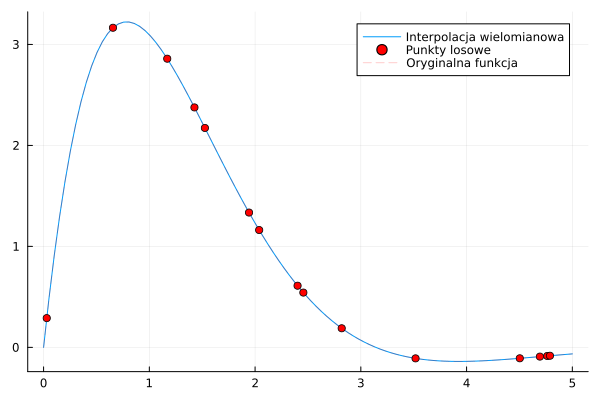

In [135]:
p = fit(Polynomial, x_samples, y_samples)

# x_vals = range(-5, stop=5.0, length=100)
y_vals_polynomials = [p(x) for x in x_vals_universal]


plot(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa")
scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

#### Porównanie metod na jednym wykresie

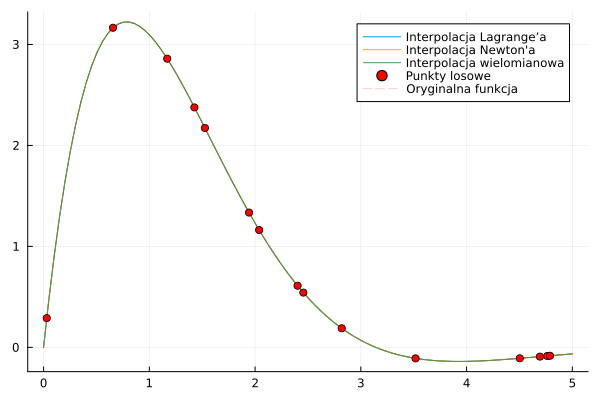

In [136]:

plot(x_vals_universal, y_vals_lagrange, label="Interpolacja Lagrange’a")
plot!(x_vals_universal, y_vals_newton, label="Interpolacja Newton'a",color=:orange)
plot!(x_vals_universal, y_vals_polynomials, label="Interpolacja wielomianowa")

scatter!(x_samples, y_samples, label="Punkty losowe", color=:red)

plot!(x_vals_universal, original_function.(x_vals_universal), label="Oryginalna funkcja", color=:red, linestyle=:dash, alpha = 0.2)

Wygląda na to że wszystkie tworzą praktycznie takie same wykresy 👌 

Pewnie dlatego że konstruują ten sam wielomian interpolacyjny tylko na różne sposoby 🐱‍👤

-> Jeśli masz n punktów, to każda z tych metod tworzy dokładnie ten sam unikalny wielomian stopnia n−1, który przechodzi przez te punkty.

### Zadanie 4

Przygotowanie danych

In [137]:
x_test_vals = []
y_test_lagrange_avg = []
y_test_lagrange_std = []

y_test_newton_prep_avg = []
y_test_newton_prep_std = []

y_test_newton_eval_avg = []
y_test_newton_eval_std = []

y_test_newton_full_avg = []
y_test_newton_full_std = []

y_test_poly_prep_avg = []
y_test_poly_prep_std = []

y_test_poly_eval_avg = []
y_test_poly_eval_std = []

y_test_poly_full_avg = []
y_test_poly_full_std = []

original_function(x) = sin(x)*exp(-x)*10

function jit_warmup()
    original_function(x) = sin(x) * exp(-x) * 10

    x_min = 0
    x_max = 5
    x_samples = sort(rand(15) * (x_max - x_min) .+ x_min)
    y_samples = original_function.(x_samples)
    x_vals_jit = range(x_min, x_max, length=100)

    # Lagrange (wywołanie samej funkcji interpolacyjnej)
    _ = [lagrange_interpolation(x_samples, y_samples, x) for x in x_vals_jit]

    # Newton
    newt = NewtonInterpolation(x_samples, y_samples)
    _ = [NewtonHorner(newt, x, x_samples) for x in x_vals_jit]

    # Polynomials.jl
    p = fit(Polynomial, x_samples, y_samples)
    _ = [p(x) for x in x_vals_jit]

    return nothing
end
    

jit_warmup()
    

for samples_amount in 500:500:3000
    push!(x_test_vals, samples_amount)

    # tymczasowe listy do przechowywania 10 wyników
    times_lagrange = Float64[]
    times_newton_prep = Float64[]
    times_newton_eval = Float64[]
    times_poly_prep = Float64[]
    times_poly_eval = Float64[]

    for j in 1:11
        x_min = 0
        x_max = samples_amount

        x_samples_time = sort(rand(samples_amount) * (x_max - x_min) .+ x_min)
        y_samples = original_function.(x_samples_time)
        x_vals_time = range(x_min, x_max, length=100)

        # Newton - przygotowanie
        time = @elapsed newt = NewtonInterpolation(x_samples_time, y_samples)
        j > 1 && push!(times_newton_prep, time)

        # Newton - obliczanie wartości
        time = @elapsed _ = [NewtonHorner(newt, x, x_samples_time) for x in x_vals_time]
        j > 1 && push!(times_newton_eval, time)

        # Polynomials - przygotowanie
        time = @elapsed p = fit(Polynomial, x_samples_time, y_samples)
        j > 1 && push!(times_poly_prep, time)

        # Polynomials - obliczanie wartości
        time = @elapsed _ = [p(x) for x in x_vals_time]
        j > 1 && push!(times_poly_eval, time)

        # Lagrange
        time = @elapsed _ = [lagrange_interpolation(x_samples_time, y_samples, x) for x in x_vals_time]
        j > 1 && push!(times_lagrange, time)
    end

    # Liczenie średnich i std dev i dodawanie do finalnych list
    push!(y_test_lagrange_avg, mean(times_lagrange))
    push!(y_test_lagrange_std, std(times_lagrange))

    push!(y_test_newton_prep_avg, mean(times_newton_prep))
    push!(y_test_newton_prep_std, std(times_newton_prep))

    push!(y_test_newton_eval_avg, mean(times_newton_eval))
    push!(y_test_newton_eval_std, std(times_newton_eval))

    push!(y_test_poly_prep_avg, mean(times_poly_prep))
    push!(y_test_poly_prep_std, std(times_poly_prep))

    push!(y_test_poly_eval_avg, mean(times_poly_eval))
    push!(y_test_poly_eval_std, std(times_poly_eval))
end


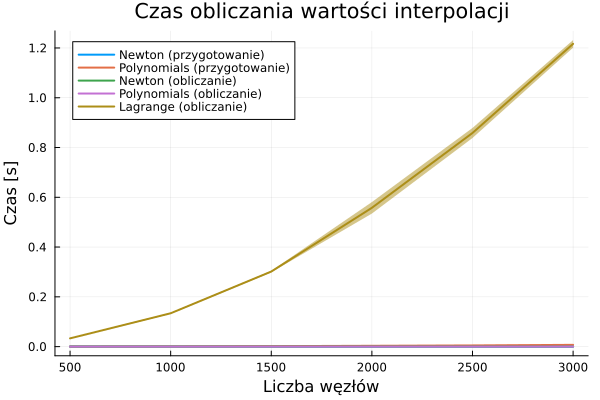

In [138]:
# Czasy przygotowania
plot(x_test_vals, y_test_newton_prep_avg;
     ribbon = y_test_newton_prep_std,
     label = "Newton (przygotowanie)",
     xlabel = "Liczba węzłów",
     ylabel = "Czas [s]",
     title = "Czas przygotowania struktur",
     lw = 2)

plot!(x_test_vals, y_test_poly_prep_avg;
      ribbon = y_test_poly_prep_std,
      label = "Polynomials (przygotowanie)",
      lw = 2)

# Czasy wyliczania wartości
plot!(x_test_vals, y_test_newton_eval_avg;
     ribbon = y_test_newton_eval_std,
     label = "Newton (obliczanie)",
     xlabel = "Liczba węzłów",
     ylabel = "Czas [s]",
     title = "Czas obliczania wartości interpolacji",
     lw = 2)

plot!(x_test_vals, y_test_poly_eval_avg;
      ribbon = y_test_poly_eval_std,
      label = "Polynomials (obliczanie)",
      lw = 2)

plot!(x_test_vals, y_test_lagrange_avg;
      ribbon = y_test_lagrange_std,
      label = "Lagrange (obliczanie)",
      lw = 2)

#### Zadanie 5

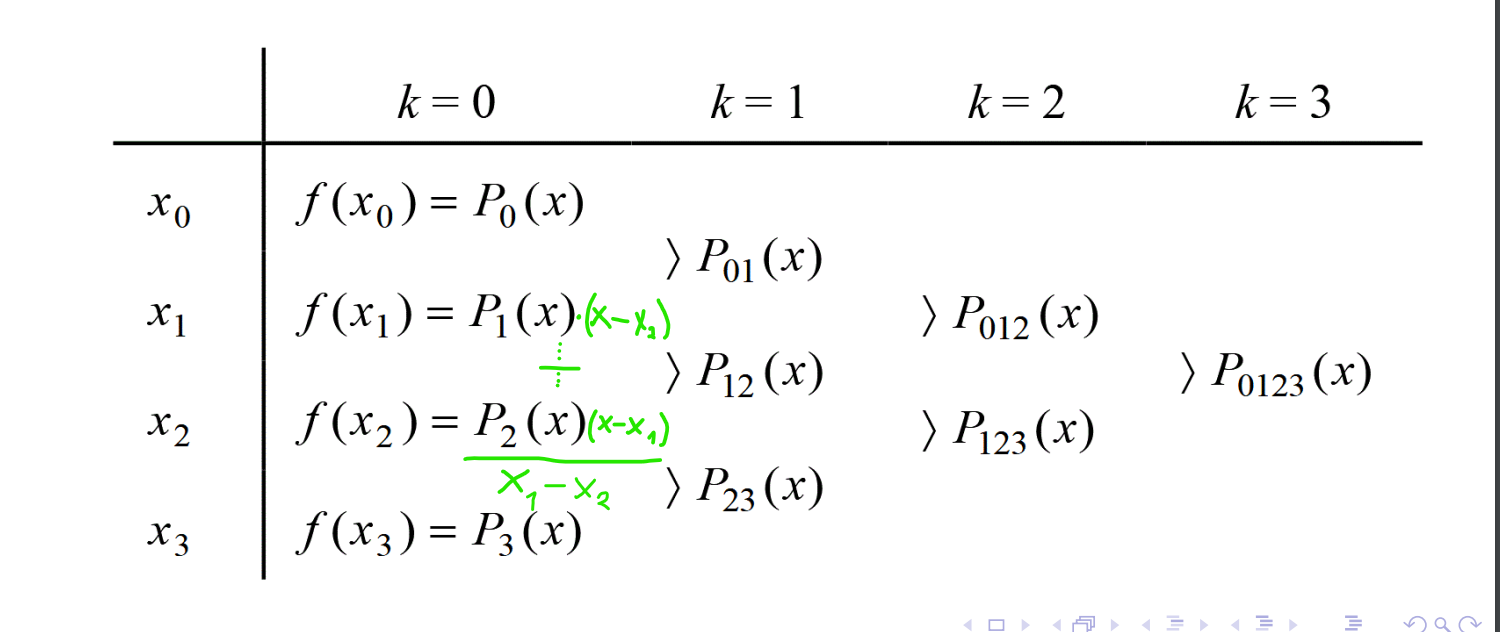

Implementacja

In [139]:
function nevilleAlgo(sample_x,sample_y,x)
    # Przygotowanie
    n = length(sample_y)
    pyramid = [0.0 for _ in 1:n, _ in 1:n]

    for i in 1:n
        pyramid[1,i] = sample_y[i]
    end

    for row in 2:n
        for col in 1:(n-row+1)
            xi = sample_x[col]
            xj = sample_x[col+row-1]
            numerator = (pyramid[row-1,col]*(x-xj) + pyramid[row-1,col+1]*(x-xi))
            denominator = xi - xj
            pyramid[row,col] = numerator / denominator
        end
    end
    return pyramid[n,1]
end    

nevilleAlgo (generic function with 1 method)